# sklearn-LDA

## 预处理

In [38]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

In [39]:
output_path = 'lda/result'
file_path = 'lda/data'
# os.chdir(file_path)
data=pd.read_excel("红书笔记详情-2025-03-23.xlsx")#content type
# os.chdir(output_path)
dic_file = "stop_dic/dict.txt"
stop_file = "stop_dic/baidu_stopwords.txt"

In [40]:
# 修改后的分词函数
def chinese_word_cut(mytext, keep_words=None):
    # 初始化保留词列表
    if keep_words is None:
        keep_words = []
    elif isinstance(keep_words, str):
        keep_words = [keep_words]
    
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file, encoding='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n', 'nz', 'vn']
    # flag_list = ['n', 'nz', 'vn', 'v', 'nr']  # 添加更多词性
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    # jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]', '', seg_word.word)
        
        # 如果词在保留词列表中，直接添加并跳过过滤
        if word in keep_words and word:
            word_list.append(word)
            continue
            
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word) < 2:  # this word is stopword
                find = 1
                break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [41]:
# keep_words = ['大觉禅寺', '大觉寺', '冰箱贴', '手串']

data["笔记内容"] = data["笔记内容"].astype(str)
data["笔记内容_CUT"] = data.笔记内容.apply(lambda x: chinese_word_cut(x))

## LDA分析

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [43]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [44]:
n_features = 200 #提取200个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)

tf = tf_vectorizer.fit_transform(data.笔记内容_CUT)

In [45]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
#                                 doc_topic_prior=0.1,
#                                 topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=5,
                          random_state=0)

### 输出每个主题对应词语 

In [46]:
n_top_words = 25
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
免费 故宫 消费 礼物 邮局 前门 稻香村 旅行 特色 美食 特产 主题 纪念品 地方 烟袋 斜街 小店 糕点 商品 店铺 中轴线 购物 价格 探店 手串
Topic #1:
天坛 故宫 免费 时间 地址 祈年殿 商店 门票 景点 旅行 纪念品 出口 文化 参观 流沙 印章 感觉 朋友 审美 特色 明信片 美食 艺术 产品 咖啡
Topic #2:
产品 礼品 纪念品 设计 文化 礼物 朋友 书签 特色 艺术 旅行 礼盒 金属 流沙 冰箱 传统 徽章 天坛 建筑 历史 细节 游客 生活 参观 纪念
Topic #3:
故宫 设计 摆件 纪念品 工艺 博物馆 寓意 图案 中轴线 款式 传统 制作 中式 造型 经典 冰箱 宫灯 文物 价格 文化 旅行 材质 礼盒 融合 生活
Topic #4:
藻井 博物馆 排队 建筑 金属 皇后 先农坛 星空 线下 木质 价格 流沙 方式 孝端 限量 产品 创店 门票 天花板 材质 建议 现场 审美 设计 官方


### 输出每篇文章对应主题 

In [47]:
import numpy as np

In [48]:
topics=lda.transform(tf)

In [49]:
topic = []
for t in topics:
    topic.append(list(t).index(np.max(t)))
data['topic']=topic
data.to_excel("data_topic.xlsx",index=False)

In [50]:
topics[0]#0 1 2 

array([0.83797826, 0.04041005, 0.04159278, 0.04000067, 0.04001824])

## 可视化 

In [51]:
import pyLDAvis
import pyLDAvis.lda_model

In [52]:
pyLDAvis.enable_notebook()
# pic = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pic = pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer, n_jobs=1)
pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
# pyLDAvis.show(pic)

## 困惑度 

In [53]:
import matplotlib.pyplot as plt

In [54]:
plexs = []
scores = []
n_max_topics = 16
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


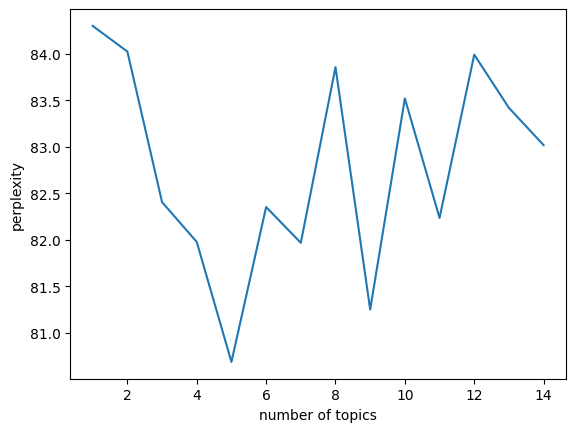

In [55]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,plexs[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()

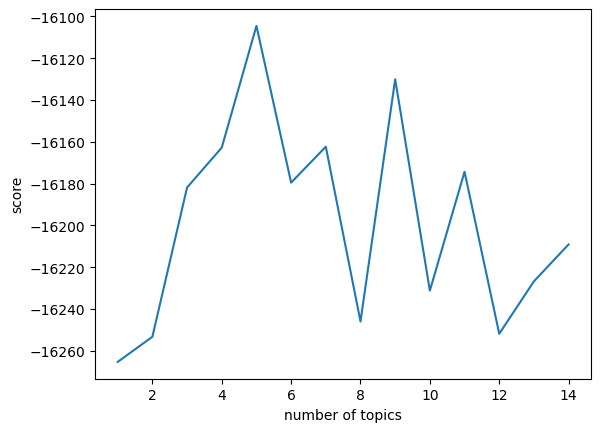

In [56]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,scores[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("score")
plt.show()